In [1]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pylab as plt

from monteloanco import Model, GroupedBatchSampler

# Read data

In [2]:
df_jsonl = pd.read_json('accepted_2007_to_2018Q4.jsonl.gz', lines=True).set_index('id')

In [3]:
df = pd.read_csv('monteloanco.csv.gz', index_col='id')
df = df.join(df_jsonl, how='inner').reset_index()

In [4]:
df.pymnt = df.pymnt.apply(torch.tensor)

# Read model

In [5]:
model = Model(embedding_size=4, input_size=len(df), device='cpu')
model.load_state_dict(torch.load('monteloanco.pt', weights_only=True))

<All keys matched successfully>

# Perform test simulation

In [6]:
row = df.sample(1).squeeze()
print(row)
hidden_states, sim_pymnts, interst_payments, principal_payments = model.forward(
    batchidx=0,
    idx=torch.tensor(row.name).repeat(100), 
    installments=torch.tensor(row.installment).repeat(100),
    loan_amnt=torch.tensor(row.loan_amnt).repeat(100), 
    int_rate=torch.tensor(row.int_rate).repeat(100))

id                                                       39038441
0                                                        1.123157
1                                                        0.123158
2                                                        0.307689
3                                                        0.395703
                                      ...                        
term_numeric                                                   36
installment                                                 244.9
loan_amnt                                                    7200
int_rate                                                    13.66
pymnt           [tensor(244.5587), tensor(244.5587), tensor(24...
Name: 22269, Length: 71, dtype: object


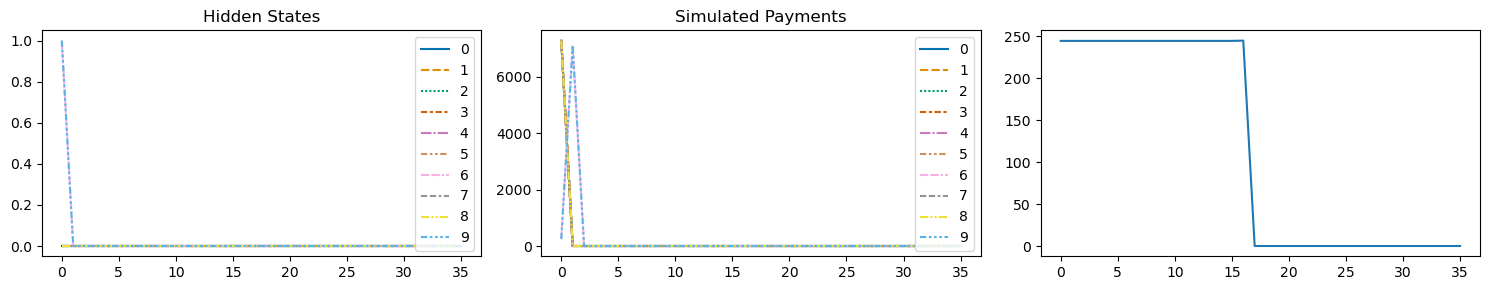

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sns.lineplot(hidden_states.detach().numpy()[:,:10], ax=ax[0], palette='colorblind')
sns.lineplot(sim_pymnts.detach().numpy()[:,:10], ax=ax[1], palette='colorblind')
sns.lineplot(row.pymnt, ax=ax[2])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Simulated Payments")
plt.tight_layout()
plt.show()

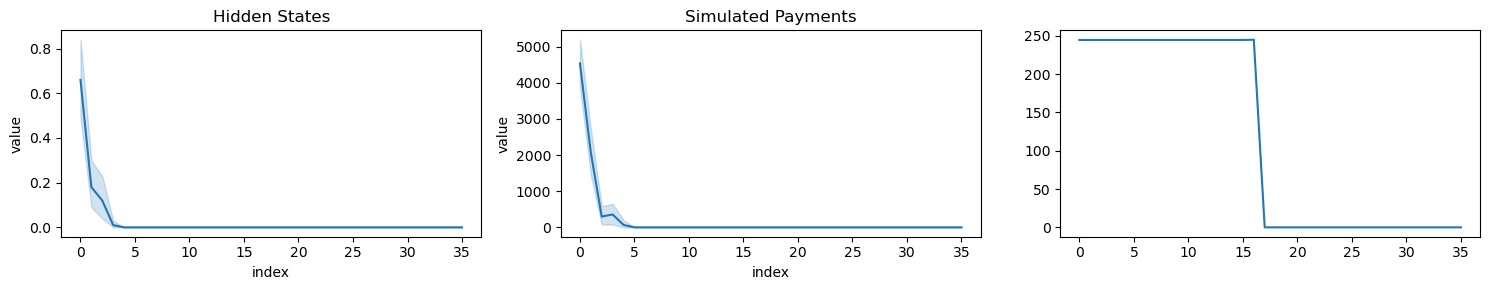

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sns.lineplot(pd.DataFrame(hidden_states.detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[0])
sns.lineplot(pd.DataFrame(sim_pymnts.detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[1])
sns.lineplot(row.pymnt, ax=ax[2])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Simulated Payments")
plt.tight_layout()
plt.show()

# Simulate full dataset

In [9]:
batch_size = 100_000
dataset = df[['id', 'installment', 'pymnt', 'loan_amnt', 'int_rate']].reset_index(names='idx').to_dict(orient='records')
grouped_batch_sampler = GroupedBatchSampler(dataset, batch_size)

In [10]:
from torch.utils.data import DataLoader

In [11]:
batches = [] 
for batchidx, batch in enumerate(DataLoader(dataset, batch_sampler=grouped_batch_sampler, num_workers=1)):
    batches.append(model.forward(batchidx, batch['idx'], batch['installment'], batch['loan_amnt'], batch['int_rate'], batch['pymnt']))
hidden_states, sim_pymnts, interst_payments, principal_payments = zip(*batches)
#hidden_states = torch.concat(hidden_states, axis=-1)
#sim_pymnts = torch.concat(sim_pymnts, axis=-1)

In [12]:
from itertools import chain

s_sim_pymnts = pd.Series(torch.concat([x.sum(axis=0) for x in sim_pymnts]), index=chain.from_iterable(grouped_batch_sampler.batches))
s_sim_pymnts

0         6517.900000
39       10460.787077
72       26348.021932
100      37252.155976
128      16059.483962
             ...     
97535    42234.069984
98348     3054.975066
98481    21104.546264
99378    15326.507390
99533    11646.720581
Length: 99879, dtype: float64

In [13]:
s_sim_pymnts.sum()

1508280974.5657706

# Score distributions

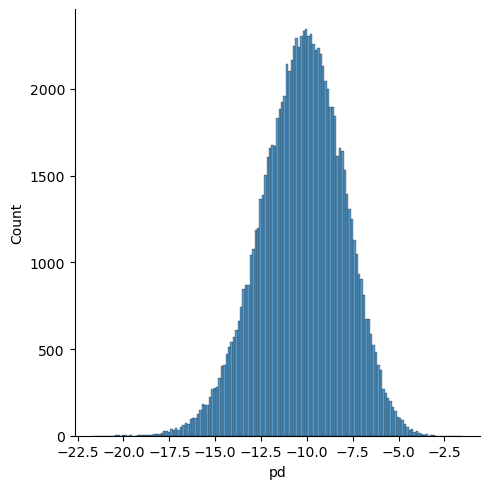

In [14]:
from scipy.special import logit

sns.displot(logit(df.pd), kind='hist')

In [15]:
df['pymnt_sum'] = [x.sum().item() for x in df.pymnt]
df = df.join(s_sim_pymnts.rename('sim_pymnts_sum'))

In [16]:
df['pd_qcut'] = pd.qcut(df.pd, q=11)
df.groupby('pd_qcut', observed=False)[['pymnt_sum', 'sim_pymnts_sum']].sum()

,pymnt_sum,sim_pymnts_sum
pd_qcut,,
"(-0.000999999605, 1.61e-06]",1.080669e+08,1.367680e+08
"(1.61e-06, 4.54e-06]",1.095946e+08,1.386847e+08
"(4.54e-06, 9.29e-06]",1.088933e+08,1.381392e+08
"(9.29e-06, 1.71e-05]",1.075011e+08,1.355326e+08
"(1.71e-05, 2.93e-05]",1.089485e+08,1.371445e+08
"(2.93e-05, 4.89e-05]",1.102759e+08,1.387309e+08
"(4.89e-05, 8.28e-05]",1.080501e+08,1.363498e+08
"(8.28e-05, 0.000145]",1.084441e+08,1.378351e+08
"(0.000145, 0.00028]",1.088954e+08,1.358657e+08
